# Exercise 27 Solution - Autoencoder

### Task
Train an autoencoder (on a dataset composed of circles) and apply it to the task of anomaly detection (using a dataset composed of circles and squares)
- Generate a normal and anomalous dataset (modify the data generation parameters if needed)
- Train the autoencoder on only the normal dataset (modify the neural network and training parameters if needed)
- Apply the autoencoder to the anomolous dataset and compare the reconstruction with reconstructions obtained with normal data
- Improve the autoencoder through the denoising autoencoder extension (corrupt the training data and modify the loss function)

### Learning goals
- Understand the autoencoder architecture and its training
- Familiarize yourself with the autoencoder implementation
- Use an autoencoder for anomaly detection

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
from torchsummary import summary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(2)

# Hyperparameters

**data generation parameters**

In [3]:
N = 128
domainLength = 1
numberOfCircles = 5
radius = 0.1

numberOfSamples = 20  #200
numberOfAnomolousSamples = 128

**neural network parameters**

In [4]:
depth = 4
numberOfFilters = 3
convolutionalLayers = 2

**training parameters**

In [5]:
epochs = 200
lr = 5e-3
batchSize = 64
regularization = 1e-4

## Data generation

**helper functions to generated normal and anomolous data**

In [6]:
def generateNonOverlappingCirclesInDomain(N, domainLength, numberOfCircles, radius):
    domain = np.ones((N, N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    x, y = np.meshgrid(x, y)

    for i in range(numberOfCircles):
        overlap = True
        while overlap == True:
            xc = np.random.uniform(radius, domainLength - radius)
            yc = np.random.uniform(radius, domainLength - radius)

            mask = (x - xc) ** 2 + (y - yc) ** 2 < radius ** 2
            if ~np.any(domain[mask] == -1):
                overlap = False
        domain[mask] = -1
    return domain


def generateAnomolousDataInDomain(N, domainLength, numberOfCircles, radius, numberOfSquares):
    domain = np.ones((N, N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    x, y = np.meshgrid(x, y)

    for i in range(numberOfCircles):
        overlap = True
        while overlap == True:
            xc = np.random.uniform(radius, domainLength - radius)
            yc = np.random.uniform(radius, domainLength - radius)

            if i >= numberOfSquares:
                mask = (x - xc) ** 2 + (y - yc) ** 2 < radius ** 2
            else:
                mask = x > xc - radius
                mask *= x < xc + radius
                mask *= y > yc - radius
                mask *= y < yc + radius
            if ~np.any(domain[mask] == -1):
                overlap = False
        domain[mask] = -1
    return domain

**data generation**

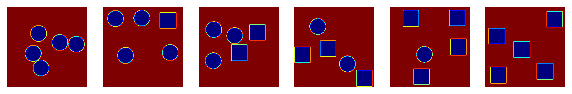

In [7]:
normalSamples = torch.zeros((numberOfSamples, 1, N, N))
for i in range(numberOfSamples):
    normalSamples[i, 0] = torch.from_numpy(
        generateNonOverlappingCirclesInDomain(N, domainLength, numberOfCircles, radius)).to(torch.float32)
torch.save(normalSamples, "data/normalData.pt")

sampleList = []
anomalySamples = torch.zeros((numberOfSamples, 1, N, N))
for j in range(0, numberOfCircles + 1):  # 0 is not anomalous
    anomalySamples = torch.zeros((numberOfAnomolousSamples, 1, N, N))
    for i in range(numberOfAnomolousSamples):
        anomalySamples[i, 0] = torch.from_numpy(
            generateAnomolousDataInDomain(N, domainLength, numberOfCircles, radius, j)).to(torch.float32)
    torch.save(anomalySamples, "data/anomalyData" + str(j) + ".pt")
    sampleList.append(anomalySamples)

fig, ax = plt.subplots(1, 6, figsize=(10, 3))
for i in range(6):
    ax[i].imshow(sampleList[i][0, 0], origin='lower', cmap='jet')
    ax[i].axis('off')
plt.show()

## Dataset definition

**load generated data into PyTorch dataset**

In [8]:
class normalDataset(Dataset):
    def __init__(self):
        self.data = torch.load("data/normalData.pt", weights_only=False)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class anomalyDataset(Dataset):
    def __init__(self, degree):
        self.data = torch.load("data/anomalyData" + str(degree) + ".pt", weights_only=False)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

## Autoencoder architecture definition

In [9]:
class autoencoder(torch.nn.Module):
    def __init__(self, depth, numberOfFilters, convolutionalLayers, bottleneckConvolutions=True):
        super().__init__()

        self.depth = depth
        self.convolutionalLayers = convolutionalLayers
        self.bottleneckConvolutions = bottleneckConvolutions

        FilterSizes = np.linspace(-1, depth - 1, depth + 1, dtype=np.int32)
        FilterSizes[1:] = 2 ** FilterSizes[1:] * numberOfFilters
        FilterSizes[0] = 1

        self.convDown = torch.nn.ModuleList()
        self.batchNormDown = torch.nn.ModuleList()
        self.activationDown = torch.nn.ModuleList()
        self.downsample = torch.nn.ModuleList()

        self.convBottleneck = torch.nn.ModuleList()
        self.batchNormBottleneck = torch.nn.ModuleList()
        self.activationBottleneck = torch.nn.ModuleList()

        self.convUp = torch.nn.ModuleList()
        self.batchNormUp = torch.nn.ModuleList()
        self.activationUp = torch.nn.ModuleList()
        self.upsample = torch.nn.ModuleList()

        for i in range(depth):
            # downsampling
            for j in range(convolutionalLayers):
                if j == 0:
                    self.convDown.append(torch.nn.Conv2d(FilterSizes[i], FilterSizes[i + 1], kernel_size=3, stride=1,
                                                         padding=1))  # ADD SECOND LAYER
                else:
                    self.convDown.append(
                        torch.nn.Conv2d(FilterSizes[i + 1], FilterSizes[i + 1], kernel_size=3, stride=1,
                                        padding=1))  # ADD SECOND LAYER
                self.batchNormDown.append(torch.nn.BatchNorm2d(FilterSizes[i + 1]))
                self.activationDown.append(torch.nn.PReLU(init=0.2))
                self.downsample.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))

                # layers at bottleneck
            for j in range(convolutionalLayers):
                self.convBottleneck.append(
                    torch.nn.Conv2d(FilterSizes[-1], FilterSizes[-1], kernel_size=3, stride=1, padding=1))
                self.batchNormBottleneck.append(torch.nn.BatchNorm2d(FilterSizes[-1]))
                self.activationBottleneck.append(torch.nn.PReLU(init=0.2))

            # upsampling
            for j in range(convolutionalLayers):
                if j == 0:
                    self.convUp.append(
                        torch.nn.Conv2d(FilterSizes[-i - 1], FilterSizes[-i - 2], kernel_size=3, stride=1, padding=1))
                else:
                    self.convUp.append(
                        torch.nn.Conv2d(FilterSizes[-i - 2], FilterSizes[-i - 2], kernel_size=3, stride=1, padding=1))
                self.batchNormUp.append(torch.nn.BatchNorm2d(FilterSizes[-i - 2]))
                self.activationUp.append(torch.nn.PReLU(init=0.2))
            self.upsample.append(torch.nn.Upsample(scale_factor=2,
                                                   mode='nearest'))  # nearest instead of bilinear as field is not continuous

    def forward(self, x):
        y = x

        # downsampling        
        for i in range(self.depth):
            for j in range(self.convolutionalLayers):
                y = self.activationDown[i * self.convolutionalLayers + j](
                    self.batchNormDown[i * self.convolutionalLayers + j](
                        self.convDown[i * self.convolutionalLayers + j](y)))
            y = self.downsample[i](y)

        # bottleneck
        if self.bottleneckConvolutions == True:
            for j in range(self.convolutionalLayers):
                y = self.activationBottleneck[j](self.batchNormBottleneck[j](self.convBottleneck[j](y)))

        # upsampling
        for i in range(self.depth):
            y = self.upsample[i](y)
            for j in range(self.convolutionalLayers):
                y = self.activationUp[i * self.convolutionalLayers + j](
                    self.batchNormUp[i * self.convolutionalLayers + j](
                        self.convUp[i * self.convolutionalLayers + j](y)))

        return y

## Training

**data preparation including training/validation split**

In [10]:
dataset = normalDataset()
datasetTraining, datasetValidation = torch.utils.data.dataset.random_split(dataset, [0.9, 0.1])
dataloaderTraining = DataLoader(datasetTraining, batch_size=batchSize, shuffle=True)
dataloaderValidation = DataLoader(datasetValidation, batch_size=10000, shuffle=False)  # all samples

**neural network instantiation**

In [11]:
model = autoencoder(depth, numberOfFilters, convolutionalLayers, bottleneckConvolutions=True)
summary(model, (1, 128, 128))
print("achieved reduction in bottleneck: {:.2f}".format(
    (numberOfFilters * (depth + 1) * (128 / 2 ** depth) ** 2) / 128 ** 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]              30
       BatchNorm2d-2          [-1, 3, 128, 128]               6
             PReLU-3          [-1, 3, 128, 128]               1
            Conv2d-4          [-1, 3, 128, 128]              84
       BatchNorm2d-5          [-1, 3, 128, 128]               6
             PReLU-6          [-1, 3, 128, 128]               1
         MaxPool2d-7            [-1, 3, 64, 64]               0
            Conv2d-8            [-1, 6, 64, 64]             168
       BatchNorm2d-9            [-1, 6, 64, 64]              12
            PReLU-10            [-1, 6, 64, 64]               1
           Conv2d-11            [-1, 6, 64, 64]             330
      BatchNorm2d-12            [-1, 6, 64, 64]              12
            PReLU-13            [-1, 6, 64, 64]               1
        MaxPool2d-14            [-1, 6,

**optimizer and history**

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=regularization)

costHistoryTrain = np.zeros(epochs)
costHistoryValidation = np.zeros(epochs)

**training loop**

In [13]:
start = time.perf_counter()
start0 = start
bestCost = 1e10

for epoch in range(epochs):

    model.train()
    for batch, sample in enumerate(dataloaderTraining):
        optimizer.zero_grad(set_to_none=True)

        cost = torch.sum((model(sample) - sample) ** 2) / len(sample) / 128 ** 2
        costHistoryTrain[epoch] += cost.detach().cpu()

        cost.backward()

        optimizer.step()

        del sample
    costHistoryTrain[epoch] /= (batch + 1)

    model.eval()
    sample = next(iter(dataloaderValidation))
    cost = torch.sum((model(sample.detach()) - sample) ** 2) / len(sample) / 128 ** 2
    costHistoryValidation[epoch] = cost.detach().cpu()

    if (epoch % 1 == 0):
        elapsed_time = time.perf_counter() - start
        string = "Epoch: {}/{}\t\tCost function (Train): {:.3E}\t\tCost function (Validation): {:.3E}\nElapsed time: {:2f}"
        print(string.format(epoch, epochs - 1, costHistoryTrain[epoch], costHistoryValidation[epoch], elapsed_time))
        start = time.perf_counter()

    # early stopping
    if bestCost > costHistoryValidation[epoch]:
        bestCost = costHistoryValidation[epoch]
        torch.save(model.state_dict(), "model")
        bestEpoch = epoch

print("Total elapsed time: {:2f}".format(time.perf_counter() - start0))
print("best epoch: {:d}".format(bestEpoch))
model.load_state_dict(torch.load("model", map_location=device, weights_only=False))  # early stopping


Epoch: 0/199		Cost function (Train): 1.053E+00		Cost function (Validation): 1.043E+00
Elapsed time: 0.134208
Epoch: 1/199		Cost function (Train): 9.238E-01		Cost function (Validation): 1.034E+00
Elapsed time: 0.117249
Epoch: 2/199		Cost function (Train): 5.624E-01		Cost function (Validation): 1.024E+00
Elapsed time: 0.142163
Epoch: 3/199		Cost function (Train): 4.687E-01		Cost function (Validation): 1.015E+00
Elapsed time: 0.115845
Epoch: 4/199		Cost function (Train): 4.287E-01		Cost function (Validation): 1.006E+00
Elapsed time: 0.119867
Epoch: 5/199		Cost function (Train): 4.040E-01		Cost function (Validation): 9.837E-01
Elapsed time: 0.115146
Epoch: 6/199		Cost function (Train): 3.859E-01		Cost function (Validation): 9.336E-01
Elapsed time: 0.096037
Epoch: 7/199		Cost function (Train): 3.773E-01		Cost function (Validation): 8.852E-01
Elapsed time: 0.101828
Epoch: 8/199		Cost function (Train): 3.676E-01		Cost function (Validation): 8.388E-01
Elapsed time: 0.112850
Epoch: 9/199		Cost 

Epoch: 76/199		Cost function (Train): 5.127E-02		Cost function (Validation): 9.619E-02
Elapsed time: 0.210663
Epoch: 77/199		Cost function (Train): 4.981E-02		Cost function (Validation): 9.186E-02
Elapsed time: 0.197005
Epoch: 78/199		Cost function (Train): 4.613E-02		Cost function (Validation): 9.315E-02
Elapsed time: 0.203641
Epoch: 79/199		Cost function (Train): 4.780E-02		Cost function (Validation): 8.894E-02
Elapsed time: 0.184731
Epoch: 80/199		Cost function (Train): 4.325E-02		Cost function (Validation): 8.864E-02
Elapsed time: 0.198906
Epoch: 81/199		Cost function (Train): 4.567E-02		Cost function (Validation): 8.739E-02
Elapsed time: 0.215848
Epoch: 82/199		Cost function (Train): 4.157E-02		Cost function (Validation): 8.819E-02
Elapsed time: 0.242773
Epoch: 83/199		Cost function (Train): 4.202E-02		Cost function (Validation): 8.606E-02
Elapsed time: 0.194519
Epoch: 84/199		Cost function (Train): 4.157E-02		Cost function (Validation): 8.471E-02
Elapsed time: 0.197481
Epoch: 85/

Epoch: 151/199		Cost function (Train): 2.246E-02		Cost function (Validation): 8.098E-02
Elapsed time: 0.222671
Epoch: 152/199		Cost function (Train): 2.089E-02		Cost function (Validation): 8.644E-02
Elapsed time: 0.212956
Epoch: 153/199		Cost function (Train): 2.119E-02		Cost function (Validation): 9.533E-02
Elapsed time: 0.230752
Epoch: 154/199		Cost function (Train): 2.499E-02		Cost function (Validation): 9.026E-02
Elapsed time: 0.240990
Epoch: 155/199		Cost function (Train): 2.886E-02		Cost function (Validation): 8.923E-02
Elapsed time: 0.246531
Epoch: 156/199		Cost function (Train): 3.187E-02		Cost function (Validation): 8.083E-02
Elapsed time: 0.247158
Epoch: 157/199		Cost function (Train): 2.786E-02		Cost function (Validation): 8.619E-02
Elapsed time: 0.233340
Epoch: 158/199		Cost function (Train): 2.715E-02		Cost function (Validation): 8.625E-02
Elapsed time: 0.225302
Epoch: 159/199		Cost function (Train): 3.446E-02		Cost function (Validation): 7.691E-02
Elapsed time: 0.225308
E

<All keys matched successfully>

## Post-processing

In [14]:
model.eval()
print("validation cost: {:.2e} training cost: {:.2e}".format(np.min(costHistoryValidation), np.min(costHistoryTrain)))

validation cost: 7.02e-02 training cost: 1.85e-02


**training history**

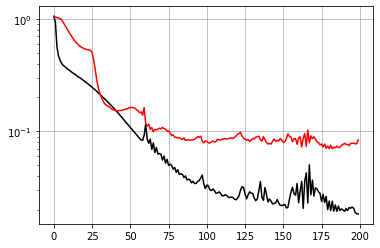

In [15]:
fig, ax = plt.subplots()
ax.grid()
ax.plot(costHistoryTrain, 'k')
ax.plot(costHistoryValidation, 'r')
ax.set_yscale('log')
plt.show()

**prediction of normal training sample**

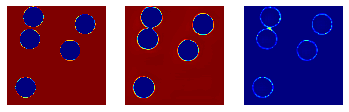

In [16]:
sample = next(iter(dataloaderTraining))
index = 0
fig, ax = plt.subplots(1, 3)
ax[0].imshow(sample[index, 0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[1].imshow(model(sample)[index, 0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[2].imshow((sample[index, 0].detach() - model(sample)[index, 0].detach().cpu()) ** 2, origin='lower', cmap='jet')
for i in range(3):
    ax[i].axis('off')
plt.show()

**prediction of normal validation sample**

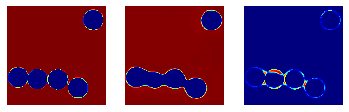

In [17]:
sample = next(iter(dataloaderValidation))
index = 0
fig, ax = plt.subplots(1, 3)
ax[0].imshow(sample[index, 0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[1].imshow(model(sample)[index, 0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[2].imshow((sample[index, 0].detach() - model(sample)[index, 0].detach().cpu()) ** 2, origin='lower', cmap='jet')
for i in range(3):
    ax[i].axis('off')
plt.show()

**prediction of anomolous (previously unseen & out of distribution) data**

128


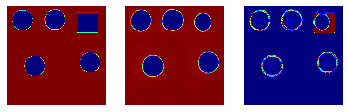

In [18]:
# change degree to choose number of squares
anomaly_dataset = anomalyDataset(degree=1)
print(len(anomaly_dataset))
anomalyPrediction = model(anomaly_dataset.data)

index = 0
fig, ax = plt.subplots(1, 3)
ax[0].imshow(anomaly_dataset[index, 0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[1].imshow(anomalyPrediction[index, 0].detach().cpu(), origin='lower', vmin=0, vmax=1, cmap='jet')
ax[2].imshow((anomaly_dataset[index, 0].detach() - anomalyPrediction[index, 0].detach().cpu()) ** 2, origin='lower',
             vmin=0, vmax=1, cmap='jet')
for i in range(3):
    ax[i].axis('off')
plt.show()

**compute reconstruction error for varying degree of anomaly (i.e., number of squares)**

In [19]:
errors = np.zeros((6, len(anomaly_dataset.data)))
for degree in range(6):
    anomaly_dataset = anomalyDataset(degree)
    anomalyPrediction = model(anomaly_dataset.data)
    errors[degree] = torch.mean((anomaly_dataset.data - anomalyPrediction) ** 2, dim=(1, 2, 3)).detach().cpu()

**histogram of reconstruction errors**

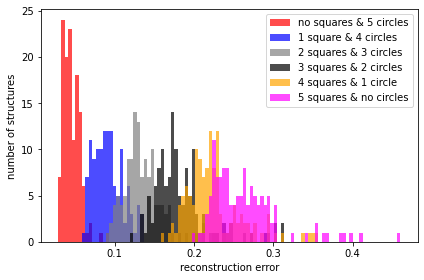

In [20]:
numberOfBins = 100
bins = np.histogram(errors, bins=numberOfBins)[1]
fig, ax = plt.subplots()

ax.hist(errors[0], bins=bins, color='r', alpha=0.7, label='no squares & 5 circles')
ax.hist(errors[1], bins=bins, color='b', alpha=0.7, label='1 square & 4 circles')
ax.hist(errors[2], bins=bins, color='gray', alpha=0.7, label='2 squares & 3 circles')
ax.hist(errors[3], bins=bins, color='k', alpha=0.7, label='3 squares & 2 circles')
ax.hist(errors[4], bins=bins, color='orange', alpha=0.7, label='4 squares & 1 circle')
ax.hist(errors[5], bins=bins, color='magenta', alpha=0.7, label='5 squares & no circles')

ax.set_xlabel("reconstruction error")
ax.set_ylabel("number of structures")

legend = ax.legend()
fig.tight_layout()
plt.show()